In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Tutorial 1: GP regression to a simple dataset

In this tutorial we will model a very simple dataset (taken from the excellent *<a href="https://arxiv.org/pdf/1505.02965.pdf">Gaussian Processes for Regression:
A Quick Introduction</aref>* by Mike Ebden) with a GP using a squared exponential covariance function.

The dataset consists of 6 observations, taken at inputs:
$$
\mathbf{x} = (−1.50, −1.00, −0.75, −0.40, −0.25, 0.00).
$$
The corrsponding, measured output values are:
$$
\mathbf{y} = (−1.70, −1.10, −0.3, 0.25, 0.60, 0.90).
$$
and all have measurement uncertainty $\sigma=0.3.$.

The goal of the exercise is to fit the data using a simple GP model, and to use that model to predict the observable $y_*$ at $x_*=0.4$.

## 1.0 Evaluate and plot the data

Use the cell below to evaluate $\mathbf{x}$ and $\mathbf{y}$ as `numpy` arrays and plot them.

<ErrorbarContainer object of 3 artists>

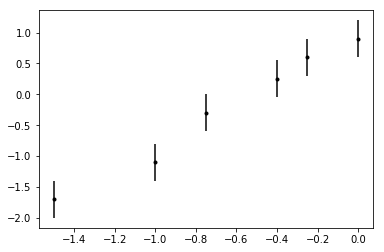

In [36]:
x = np.array([-1.50, -1.00, -0.75, -0.40, -0.25, 0.00])
y = np.array([-1.70, -1.10, -0.3, 0.25, 0.60, 0.90])
sig = 0.3
plt.errorbar(x,y,yerr=sig,fmt='k.')

## 1.1: Evaluate the covariance matrix

To model the data using a GP we need to select a covariance function. The data look like they follow a fairly simple smooth trend, so the squared exponential kernel, which is one of the simplest and most widely used, is a reasonable choice. It is given by:
$$
k_{\rm SE}(x,x') = A \exp \left[ - \Gamma (x-x')^2 \right]
$$
where $A$ is the variance and $\Gamma$ the inverse length scale. This kernel gives rise to smoothly varying, infinitely differentiable functions.

In the cell below, define a function `SEKernel` that computes the covariance matrix for the above kernel function. The function should take three mandatory arguments: an array containing the hyper-parameters of the covariance function ($A$ and $\Gamma$ in the equation above), and two arrays of input values. The function returns a 2-D array with shape $(N, M)$, where $N$ and $M$ are the numbers of inputs in each of the input arrays.

*Hint: you may find the function `cdist` from the module `scipy.spatial.distance` useful to evaluate a 2-D array of squared distances between the inputs. However, note that it expects input arrays of shape $(N,D)$ where $D$ is the number of dimensions of the inputs.*

*Hint: As we have defined, the parameters of the covariance function, $A$ and $\Gamma$, should always be positive. It will make things easier later on if we define the function in terms of the log of the parameters, so that their positivity is guaranteed.

In [46]:
from scipy.spatial.distance import cdist
def SEKernel(par, x1, x2):
    A, Gamma = np.exp(par)
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    return A * np.exp(-Gamma*D2)

Now we need to test this function and see if it does what we want. In the absence of prior information on $A$ and $\Gamma$, let's set them both to unity for now.

In the cell below, generate a set of $30$ one-dimensional inputs regularly spaced between -2 and 1 and store them in a variable called `xtest`, then compute the covariance matrix for these inputs, for $A=\Gamma=1$. Store the results in a variable called `Ktest`, and display it using `matplotlib`'s `imshow` function.

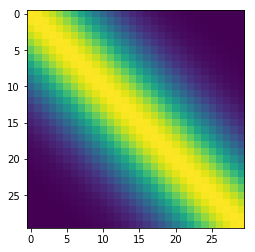

In [47]:
xtest = np.linspace(-2,1,30)
Ktest = SEKernel([0.0,0.0],xtest,xtest)
plt.imshow(Ktest,interpolation='none');

## 1.2 Draw samples from the prior

As discussed in the lectures, the choice of covariance function and hyper-parameters sets up a probability distribution over functions. But do the functions allowed by this specific choice look reasonable given the data? To answer that question, we will ***draw samples from the the GP prior***.

In the cell below, draw 5 samples from the distribution set up by `Ktest` and plot them alongside the data. You should assume that the mean of the GP is zero everywhere.

*Hint:* You may find the function `multivariate_normal` from the module `numpy.random` useful.

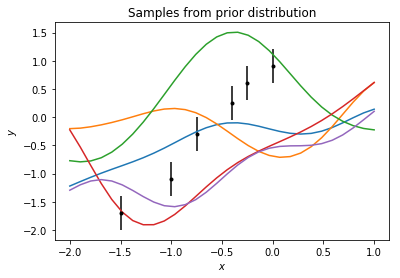

In [48]:
from numpy.random import multivariate_normal
plt.errorbar(x,y,yerr=sig,fmt='k.')
samples = multivariate_normal(np.zeros(len(xtest)),Ktest,5)
plt.plot(xtest,samples.T)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Samples from prior distribution');

## 1.3 Evaluating the likelihood

By eye, the samples from the prior look like a reasonable match to the data, in the sense that they display roughtly the right amplitude, length scale and degree of smoothness. To quantify this properly, we need to write  a function to evaluate the likelihood.

Under a GP model, the likelihood is simply a multivariate Gaussian with mean vector $\mathbf{m}$ and covariance matrix $K$:
$$
p(\mathbf{y} \mid \mathbf{m}, \mathbf{K}) = \mathcal{N}(\mathbf{m},\mathbf{K}).
$$
Assuming the mean function is zero everywhere for now (we will add non-trivial mean functions later), the negative log likelihood is then:
$$
\mathrm{NLL} = - \log \mathrm{p}(\mathbf{y}\mid \mathbf{m},\mathbf{K}) = \frac{1}{2} \mathbf{y}^{\mathrm{T}} \,
\mathbf{K}^{-1} \, \mathbf{y} + \frac{1}{2} \log |\mathbf{K}| + \frac{N}{2} \log 2 \pi
$$
where $N$ is the number of observations.

As discussed in the lectures, any white noise from observational uncertainties must be added to the diagonal elements of the covariance matrix.

Complete the definition of the function `SE_NLL` below. The function should evaluate the covariance matrix and return the ***negative log likelihood*** as given by the above equation. The first argument, `p`, contains the hyper-parameters of the squared exponential covariance function. The remaining arguments should be self-explanatory. 

*NB: we evaluate the ***log*** likelihood because this avoids an expensive exponential calculation, and the ***negative*** of it so we can later minimize it (i.e. maximise the likleihood) using one of the standard `Python` optimizing routines.*

*Hint: Use `numpy.dot` and `numpy.linalg.inv` to do the matrix algrebra. You will also need to evaluate the log of the determinant of the covariance matrix, for this you can use `numpy.linalg.slogdet`. These functions particularly stable or efficient, but code optimisation is not the point of this tutorial. In tutorial 2 we will look at some ready-made GP packages, which use much more optimized matrix inversion techniques.** 

In [49]:
from numpy.linalg import inv
from numpy.linalg import slogdet
def SE_NLL(p,x,y,sig):
    # Evaluate the covariance matrix
    K = SEKernel(p,x,x)
    # Add the white noise term
    K += np.identity(x.shape[0]) * sig**2
    # invert it
    Ki = inv(K)
    # evaluate each of the three terms in the NLL
    term1 = 0.5 * np.dot(y,np.dot(Ki,y))
    term2 = 0.5 * slogdet(K)[1]
    term3 = 0.5 * len(y) * np.log(2*np.pi)
    # return the total
    return term1 + term2 + term3

Now let's evaluate the log likelihood for our initial guess of hyper-parameters, $A=\Gamma=1$.

In [50]:
par_init = np.array([0.0,0.0])
print(SE_NLL(par_init, x, y, sig))

4.5933086846223645


## 1.4 Fitting for the hyper-parameters

This looks like a low number, but in isolation, the log likelihood value doesn't tell us much. Can we find a better set of hyper-parameters? To do this we must maximise the (log) likelihood with respect to the hyper-parameters. Use the next cell to do this.

*Hint: Use the `fmin` funciton from the `scipy.optimize` module.*

In [51]:
from scipy.optimize import fmin
par_ML = fmin(SE_NLL,par_init,args=(x, y, sig))
print(par_ML)

Optimization terminated successfully.
         Current function value: 4.364701
         Iterations: 49
         Function evaluations: 95
[ 0.64237344 -0.77462966]


Ok, so we now have a new set of hyper-parameters that give a (slightly) improved log likelihood. We are ready to start making ***predictions***.

## 1.5 Single-point prediction

As we saw in the lecture, the posterior distribution (also called the conditional or predictive distribution) for $y$ evaluated at test input $x_*$, given the observations, is a multivariate Gaussian with mean and variance
$$
\begin{array}{lll}
\mathbb{E}[y_*] \equiv \overline{y_*} & = & \mathbf{k}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{y}, \\
\mathbb{V}[y_*] & = & k(x_*,x_*,\boldsymbol{\phi}) - \mathbf{k}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{k}_*,
\end{array}
$$
where $\mathbf{k}_*$ is the vector of covariances between the test point and the training points, such that $k_{*,i}=k(x_i,x_*)$.

Use the equations above to evaluate the predictive mean and variance at $x_*=0.4$, given the best-fit hyper-parameters, and plot them together with the observed data.

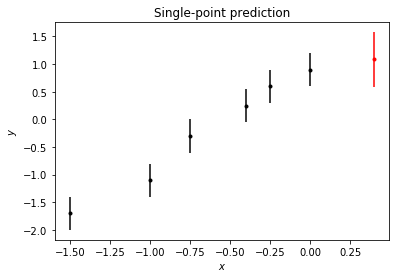

In [52]:
K = SEKernel(par_ML,x,x) + np.identity(len(x)) * sig**2
Ki = inv(K)
x_star = np.array([0.4])
ks = SEKernel(par_ML,x_star,x)
y_star = np.dot(ks, np.dot(Ki, y))
kss = SEKernel(par_ML,x_star,x_star)
var_star = kss - np.dot(ks, np.dot(Ki, ks.T))
sig_star = np.sqrt(var_star)
plt.errorbar(x,y,yerr=sig,fmt='k.')
plt.errorbar(x_star,y_star,yerr=sig_star,fmt='r.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Single-point prediction');

## 1.6 The predictive distribution

But of course the GP_predict function allows us to make predictions for *any* inputs. In the cell below, complete the definition of the function `SE_Pred`, which computes and returns the mean and covariance of the predictive distribution for the squared exponential function, given the hyper-parameters, and a set of observations $(\mathbf{x},\mathbf{y},\mathbf{\sigma})$, where $\mathbf{\sigma}$ are the uncertainties associated with each observation, at a given set of test inputs $\mathbf{x}_*$. 

In the following cell, evaluate and plot the mean and 95\% confidence interval of the predictive distribution for 100 regularly spaced test points between -3 and 3.

*Hint: the variance $\sigma^2$ of the distribution is given by the diagonal elements of the covariance matrix, and the 95% confidence interval is bounded by the mean plus or minus 2 $\sigma$. You can us the `matplotlib` function `fill_between` to shade the area within the 95% confidence interval.*

In [53]:
def SE_Pred(p, x, y, sig, x_star):
    # evaluate the covariance matrix for pairs of observed inputs
    K = SEKernel(p, x, x) 
    # add white noise
    K += np.identity(x.shape[0]) * sig**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = SEKernel(p, x_star, x_star)
    # evaluate the cross-term
    Ks = SEKernel(p, x_star, x)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, y))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov

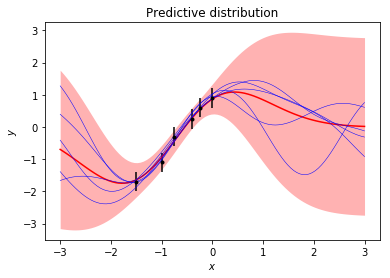

In [54]:
plt.errorbar(x,y,yerr=sig,fmt='k.')
x_star = np.linspace(-3,3,100)
y_star,cov_star = SE_Pred(par_ML,x,y,sig,x_star)
sig_star = np.sqrt(np.diag(cov_star))
plt.plot(x_star,y_star,'r-')
plt.fill_between(x_star, y_star + 2 * sig_star, y_star - 2 * sig_star, color = 'r', lw=0, alpha=0.3)
samples = multivariate_normal(y_star,cov_star,5).T
plt.plot(x_star,samples,'b-',lw=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Predictive distribution');


Some things to note:
- while the prior distribution is stationary (the mean and variance are constant over the input range) the predictive distribution is not;
- far away grom observations, the predictive distribution returns to the prior
- where observations are close together compared to the lenght scale of the GP, the predictive ability is good: the 95% confidence interval is narrow and the samples from the predictive distribution all behave similarly
- the predictive mean doesn't have the same behaviour as the samples from the predictive distribution: the samples are more "wiggly".

## 1.6 Including a mean function

So far we have assumed the mean of the GP was zero everywhere, but is it? There could be a linear trend there, for example. To test this hypothesis, let us define new functions to compute the likelihood and the predictive distribution of the GP, assuming a linear mean function.

In the cells below, define a wrapper function around your existing `SE_NLL` function, that allows for the inclusion of a linear mean function, and use it to fit for the parameters of the mean function and the GP hyper-parameters simultaneously. 

*Hint: You will need to come up with an initial guess for the parameters of the linear mean function. As the latter should absorb most of the variation seen in the data, you may also wish to set the initial estimate of the GP variance to a lower value than before.*

In [55]:
def SE_Lin_NLL(p,x,y,sig):
    m = p[0] + p[1] * x
    r = y - m
    return SE_NLL(p[2:],x,r,sig)
par_init_lin = np.array([1.0,1.5,-2,-0.7])
par_ML_lin = fmin(SE_Lin_NLL,par_init_lin,args=(x, y, sig))
print(par_ML_lin)

Optimization terminated successfully.
         Current function value: -1.231062
         Iterations: 262
         Function evaluations: 491
[  0.96558333   1.83166666 -36.73064498   3.43956188]


Now let's compare the predictive distributions for the model with and without the linear trend. Start by writing a wrapper function around your earlier `SE_Pred` function, to include the linear trend, and then use it to plot the predictive distribution. Compare this to the predictive distribution in the zero mean case, and discuss.

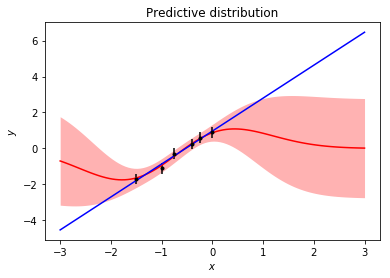

In [70]:
def SE_Lin_Pred(p,x,y,sig,x_star):
    m = p[0] + p[1] * x
    r = y - m
    mu,cov = SE_Pred(p[2:],x,r,sig,x_star)
    mu += p[0] + p[1] * x_star
    return mu,cov
plt.errorbar(x,y,yerr=sig,fmt='k.')
y_star_lin,cov_star_lin = SE_Lin_Pred(par_ML_lin,x,y,sig,x_star)
sig_star_lin = np.sqrt(np.diag(cov_star_lin))
plt.plot(x_star,y_star,'r-')
plt.fill_between(x_star, y_star + 2 * sig_star, y_star - 2 * sig_star, color = 'r', lw=0, alpha=0.3)
plt.plot(x_star,y_star_lin,'b-')
plt.fill_between(x_star, y_star_lin + 2 * sig_star_lin, y_star_lin - 2 * sig_star_lin, \
                 color = 'b', lw=0, alpha=0.3)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Predictive distribution');


## 1.7 Model comparison

In your opinion, is the model with or without a linear trend supported by the data? Remember to take into account the fact that the two models have a different number of free parameters.

*Hint: use the ***Bayesian information criterion*** or the ***Akaike information criterion***.*

In [65]:
BIC_SE = np.log(len(x)) * 2 + 2 * SE_NLL(par_ML,x,y,sig)
BIC_SE_Lin = np.log(len(x)) * 4 + 2 * SE_Lin_NLL(par_ML_lin,x,y,sig)
print(BIC_SE,BIC_SE_Lin,BIC_SE-BIC_SE_Lin)
AIC_SE = 2 * 2 + 2 * SE_NLL(par_ML,x,y,sig)
AIC_SE_Lin = 2 * 4 + 2 * SE_Lin_NLL(par_ML_lin,x,y,sig)
print(AIC_SE,AIC_SE_Lin,AIC_SE-AIC_SE_Lin)

12.312919938806996 4.7049136604941 7.608006278312896
12.729401000350887 5.53787578358188 7.191525216769007


In [66]:
# The difference in BIC is 7.6, and in AIC it is 7.2. Both of these measures indicate strong support 
# for the model with a linear mean function over the model with zero mean.

Do you notice anything interesting about the covariance hyper-parameters for the model with the linear trend? 

In [67]:
# The GP variance is tiny -- basically, a linear trend plus white noise suffice to explain the data. 
# This illustrates the Occam's razor built into GP regression: it ascribes variations
# in the data to the mean function, if possible, in preference to the covariance. 

Note that the predictive distributions in both cases do not include uncertainties on the hyper-parameters (the parameters of the mean function and of the covariance function). In the next tutorial we will see how to account for those uncertainties too.

## 1.8 Cross validation

In section 1.7 we used the BIC and/or AIC to compare models with and without mean functions. That's fine if what we care about is having the "right" model. If instead we care about prediction, then cross-validation might be a better choice of method for model selection. 

In this section, we will implement a particular type of Cross-Validation: Leave-One-Out CV, or LOO-CV. This consists in going through all the data points in turn, using them as the test data point while the rest of the data points are used for training. The final LOO-CV likelihood is the product of the individual likelihoods (sum of the log likelihoods) obtained in this way.

Complete the definition of the function `LOOCV_NLL`, and use it to determine whether the model with or without mean function has the better predictive power, given the dataset we have.

In [82]:
def LOOCV_NLL(NLL_func, p_init, x, y, sig):
    nll = 0.0
    for i in range(len(x)):
        # split the data into training and test set
        xx = np.delete(x, i)
        yy = np.delete(y, i)
        if hasattr(sig,"__len__"):
            ss = np.delete(sig,i)
            s_ = sig[i]
        else:
            ss = np.copy(sig)
            s_ = np.copy(sig)
        # fit for the hyper-parameters using the training set
        p_ = fmin(NLL_func,p_init,args=(xx,yy,ss),disp=0)        
        # evaluate the likelihood on the test set (single datum)
        nll += NLL_func(p_,np.array([x[i]]),np.array([y[i]]),s_)
    return nll
print(LOOCV_NLL(SE_NLL,par_ML,x,y,sig))
print(LOOCV_NLL(SE_Lin_NLL,par_ML_lin,x,y,sig))

9.212689133240325
-0.6048226880951468


In [83]:
# This method also supports the mode with a linear trend over the one with zero mean (not suprisingly).